# PyTorch with The Fashion MINST Dataset (Simple Project)

This notebook contains the steps for building deep neural network using PyTorch and the fashion Minst dataset where it takes an image of clothes as input and predict its class. Then, it shows the impacts of varying the hyperparameters on the accuracy of the prediction model.

## Table of Contents
#####  1. The First Training 
  - Import The Relevant Packages
  - Download and Prepare The Dataset
  - Build a Class to Fetch The Dataset
  - Define The Model, Loss Function, and Optimizer
  - Define a Training Function
  - Define an Evaluation Funtion
  - Train the Network
  - Display the Variation of the Training Loss and Accuracy
  - Results and Conclusion
##### 2. The Impact of Scaling the Dataset
##### 3. The Impact of Varing the Batch Size
##### 4. The Impact of Varying the Loss Optimizer
##### 5. The Impact of Varying the Learning Rate
##### 6. The Impact of Learning Rate Annealing



## 1. The First Training

### 1.1 Import The Relevant Packages

In [1]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on cuda if GPU is available

### 1.2 Download and Prepare The Dataset

In [2]:
from torchvision import datasets
data_folder = "\Datasets"                         #can be any directory to download the dataset
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [3]:
train_images = fmnist.data                                #training images 
train_targets = fmnist.targets                            #images labels (classes)

In [4]:
print(f"Number of training images {train_images.shape[0]}")
print(f"Number of classess {len(train_targets.unique())}")
print(f"The classess {fmnist.classes}")

Number of training images 60000
Number of classess 10
The classess ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


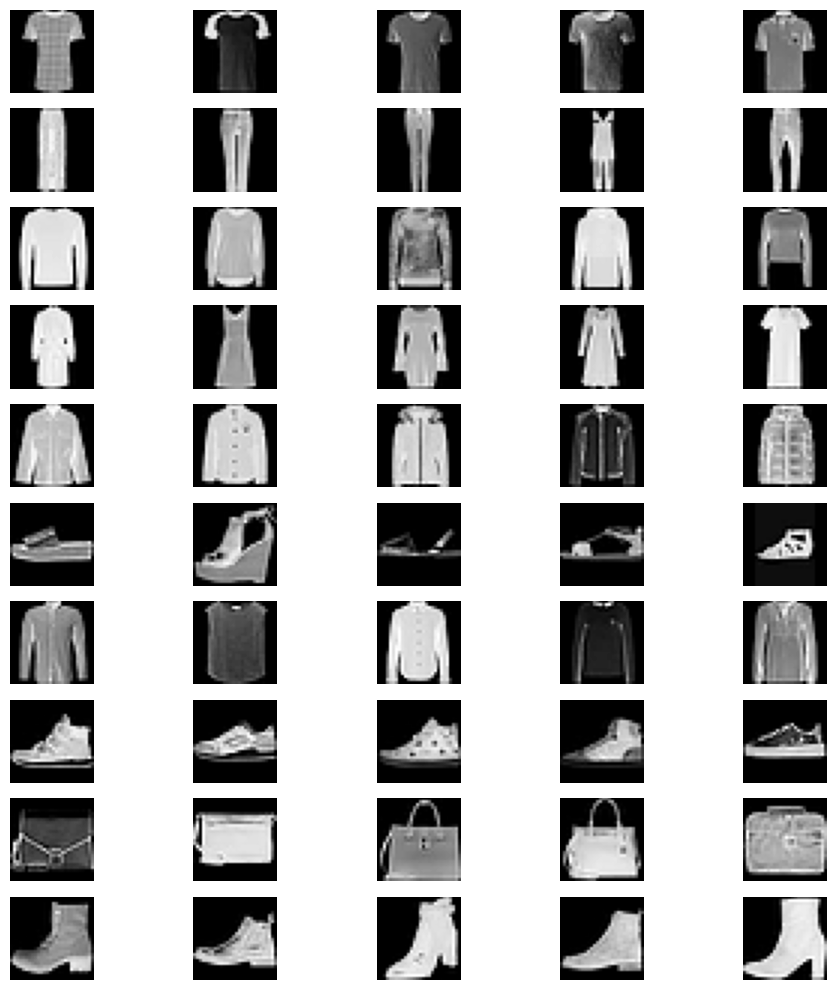

In [5]:
#Create a plot of 10*5 grid where each row belongs to a class to visualize the dataset
row,col = len(train_targets.unique()) , 5
fig, ax = plt.subplots(row,col, figsize = (10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_targets == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x= train_images[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

### 1.3 Build a Class to Fetch The Dataset

In [6]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x= x.float()                #convert the images to a float point numbers
        x = x.view(-1,28*28)        #flatten each image
        self.x , self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        x,y = self.x[index], self.y[index]
        return x.to(device), y.to(device)       #resgister the input and the output data to the device "cuda" to train on GPU

In [7]:
train_data = FMNISTDataset(train_images,train_targets) 
#use Dataloader to sample 32 data points randomly for each batch size
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True) 

### 1.4 Define The Model, Loss Function, and Optimizer

In [62]:
#Create a model with one hidden layer (1000 neurons) and the output is a 10-neuron layer to predict the 10 classess
def build_model(optimizer = SGD, lr = 1e-2 ):
    
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000,10)
                         ).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr = lr)   #initialize the learning rate to 0.01
    
    return model , loss_function, optimizer


### 1.5 Define a Training Function

In [9]:
def train_batch(input_batch, targets, model, loss_function, optimizer):
    model.train()                                        
    predictions = model(input_batch)                     #perfom forward propagation
    batch_loss = loss_function(predictions,targets)      #compute the loss value 
    batch_loss.backward()                                #perfom backward propagation
    optimizer.step()                                     #calculate new weights
    optimizer.zero_grad()                                #flush the gradients for next batch of calculations
    
    return batch_loss.item()                             #return the loss value
      

### 1.6 Define an Evaluation Funtion 

In [10]:
@torch.no_grad()                       #disable the gradients calculation
def get_accuracy(input_batch, targets, model):
    model.eval()
    predictions = model(input_batch)              #perfom forward propagation
    max_values, argmaxes = predictions.max(-1)    #get argmax index for each row
    is_correct = argmaxes ==targets               #compare argmax with tragets to check that each row predicts correctly
    
    return is_correct.cpu().numpy().tolist()      #return the result,register it to the cpu, and convert it to numpy array

### 1.7 Train the Network

In [11]:
model,loss_function, optimizer = build_model(optimizer=SGD,lr=1e-2)
def train(epoch_number):
    losses, accuracies = [], []                      # define lists to contain the loss and accuracy values of each epoch
    for epoch in range (epoch_number):               #define the number of the epochs
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       #define lists to contain the loss and accuracy values of each batch

        for batch in (iter(train_data_loader)):      #create batches of training data by iterating thorugh data loader
            input_batch, targets = batch                     #unpack the batch 
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  #train the batch

            batch_losses.append(batch_loss)                               #store the loss value of each batch
        epoch_loss = np.array(batch_losses).mean()                        #get the mean of the loss values of all batches
        losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        print('<--------------------------------------------------------->')
        
    return losses, accuracies

lossses, accuracies = train(10)

Epoch: 1
Train Loss: 25.765
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 2.206
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 2.211
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 2.124
Train Accuracy: 18%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 2.150
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 2.219
Train Accuracy: 13%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 2.236
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 8
Train Loss: 2.149
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 9
Train Loss: 2.135
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 10
Train Loss: 2.192
Train Ac

### 1.8 Display the Variation of the Training Loss and Accuracy

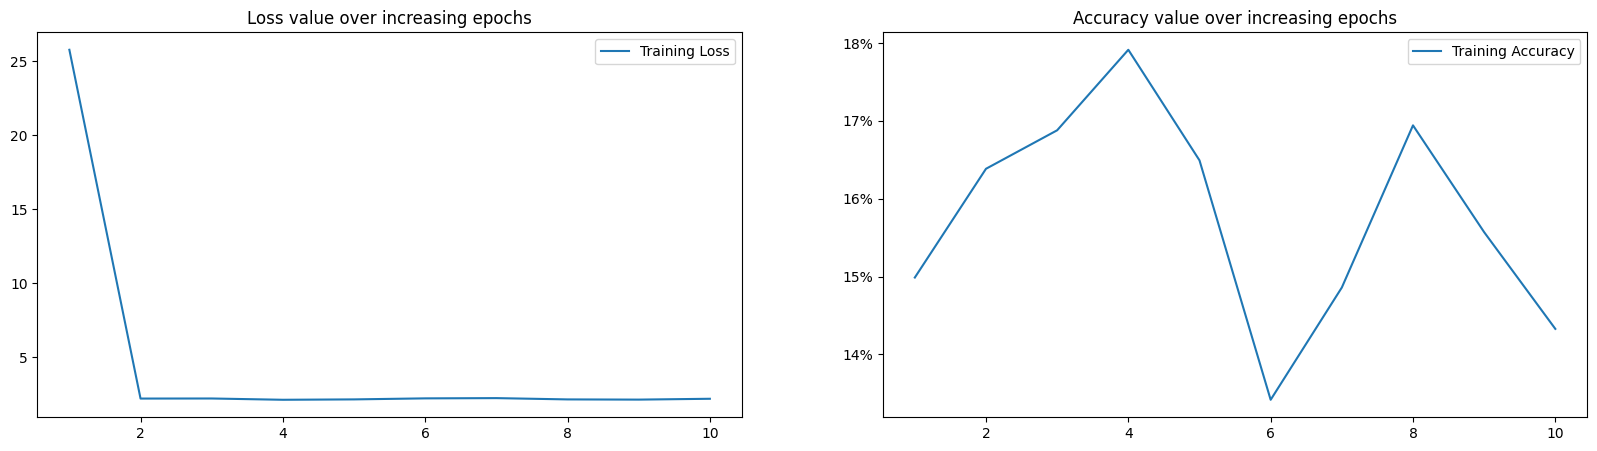

In [12]:
def display_loss_accuracy(number_epoch,lossses, accuracies):
    epochs = np.arange(number_epoch)+1
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Loss value over increasing epochs')
    plt.plot(epochs, lossses, label='Training Loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Accuracy value over increasing epochs')
    plt.plot(epochs, accuracies, label='Training Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()

display_loss_accuracy(10,lossses, accuracies)

### 1.9 Results and Conclusion

 1. The training accuracy is not good enough at the end of ten epochs
 2. The loss value did not decrease considerably over the increasing numbers of epochs
 
 ##### so we will try to change the hyperparameters to see their impact on the training accuarcy and the loss value 

## 2. The impact of Scaling the Dataset

The only change here is to modify the FMNISTDataset class where the input value is divided by the maximum possible value in the dataset which is 255. This to ensure that all the variables values are between 0 and 1.

In [13]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x= x.float()/255            #divide the input data by the maximum value
        x = x.view(-1,28*28)        
        self.x , self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        x,y = self.x[index], self.y[index]
        return x.to(device), y.to(device)       

In [14]:
train_data = FMNISTDataset(train_images,train_targets) 
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [15]:
model,loss_function, optimizer = build_model(optimizer=SGD, lr=1e-2)
lossses, accuracies = train(10)

Epoch: 1
Train Loss: 0.846
Train Accuracy: 80%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.537
Train Accuracy: 83%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.483
Train Accuracy: 83%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.454
Train Accuracy: 85%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.434
Train Accuracy: 86%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.420
Train Accuracy: 86%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.406
Train Accuracy: 86%
<--------------------------------------------------------->
Epoch: 8
Train Loss: 0.395
Train Accuracy: 87%
<--------------------------------------------------------->
Epoch: 9
Train Loss: 0.385
Train Accuracy: 87%
<--------------------------------------------------------->
Epoch: 10
Train Loss: 0.377
Train Acc

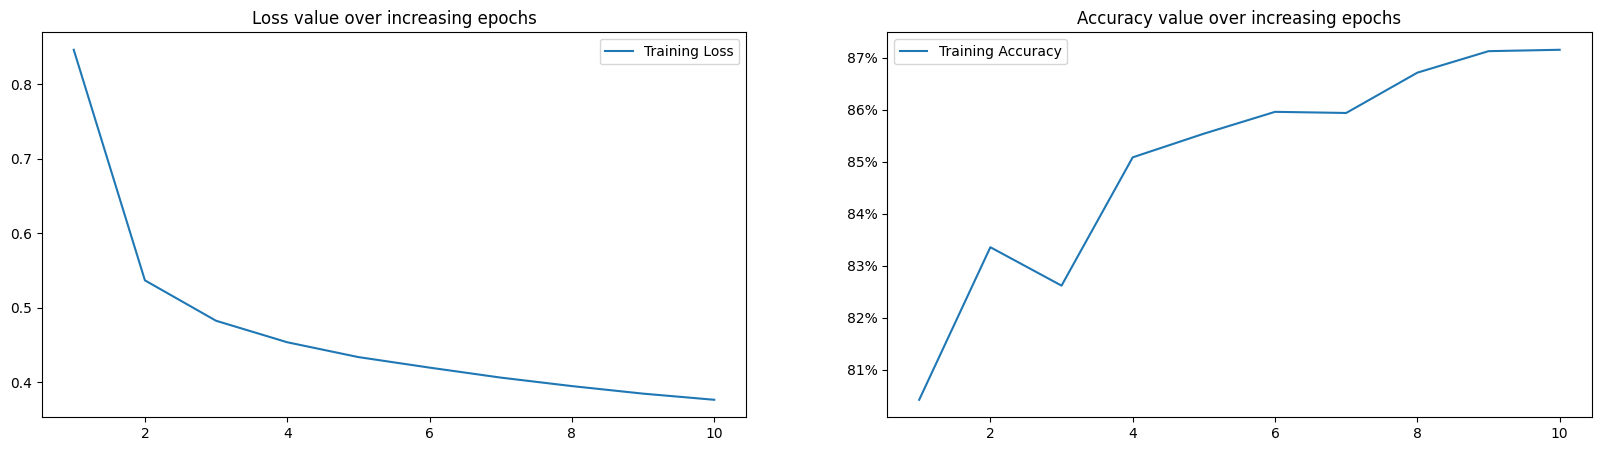

In [16]:
display_loss_accuracy(10,lossses, accuracies)

Scaling the input dataset so that it contains a much smaller range of values generally helps in achieving better model accuracy.

## 3. The Impact of Varing the Batch Size

The change here is we will rerun the code to generate the validation dataset and change the batch size from 32 to 10,000 to see the impact on the loss value and prediction model accuracy.

In similar mannaer download and import the validation dataset by specifiying: 
#### Train = False

In [17]:
validation_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
validation_images = validation_fmnist.data                                
validation_targets = validation_fmnist.targets  

In [18]:
def get_data(batchsize):
    train_data = FMNISTDataset(train_images,train_targets) 
    train_data_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True) 
    validation_data = FMNISTDataset(validation_images,validation_targets) 
    validation_data_loader = DataLoader(validation_data, batch_size=len(validation_images), shuffle=False) 
    
    return train_data_loader, validation_data_loader


In [19]:
#define a function to calculate the loss value of the validation dataset
@torch.no_grad()
def get_validation_loss_value(input_batch, targets,model):
    model.eval()
    predictions = model(input_batch)
    validation_loss = loss_function(predictions,targets)
    
    return validation_loss.item() 

In [20]:
train_data_loader, validation_data_loader = get_data(32)

In [58]:
model,loss_function, optimizer = build_model(optimizer=SGD, lr=1e-2)

In [22]:
def train_with_validation(epoch_number):
    train_losses, train_accuracies = [], []   
    validation_losses, validation_accuracies = [], [] 
    for epoch in range (epoch_number):               
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       

        for batch in (iter(train_data_loader)):      
            input_batch, targets = batch                     
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  

            batch_losses.append(batch_loss)                               
        epoch_loss = np.array(batch_losses).mean()                        
        train_losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        train_accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        
        for batch in (iter(validation_data_loader)):
            input_batch, targets = batch
            validation_loss_value = get_validation_loss_value(input_batch, targets, model)
            validation_accuracy = get_accuracy(input_batch, targets, model)
            
        validation_losses.append(validation_loss_value)
        print(f"Validation Loss: {validation_loss_value:0.3f}")
        valiation_epoch_accuracy = np.mean(validation_accuracy)
        print(f"Validation Accuracy: {valiation_epoch_accuracy*100:0.0f}%")
        validation_accuracies.append(valiation_epoch_accuracy)
        print('<--------------------------------------------------------->')
        
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [23]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 0.835
Train Accuracy: 81%
Validation Loss: 0.601
Validation Accuracy: 79%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.536
Train Accuracy: 83%
Validation Loss: 0.535
Validation Accuracy: 81%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.484
Train Accuracy: 84%
Validation Loss: 0.496
Validation Accuracy: 82%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.456
Train Accuracy: 84%
Validation Loss: 0.484
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.437
Train Accuracy: 85%
Validation Loss: 0.459
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.423
Train Accuracy: 86%
Validation Loss: 0.445
Validation Accuracy: 84%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.410
Train Accuracy: 86%
Validation Loss: 0.437


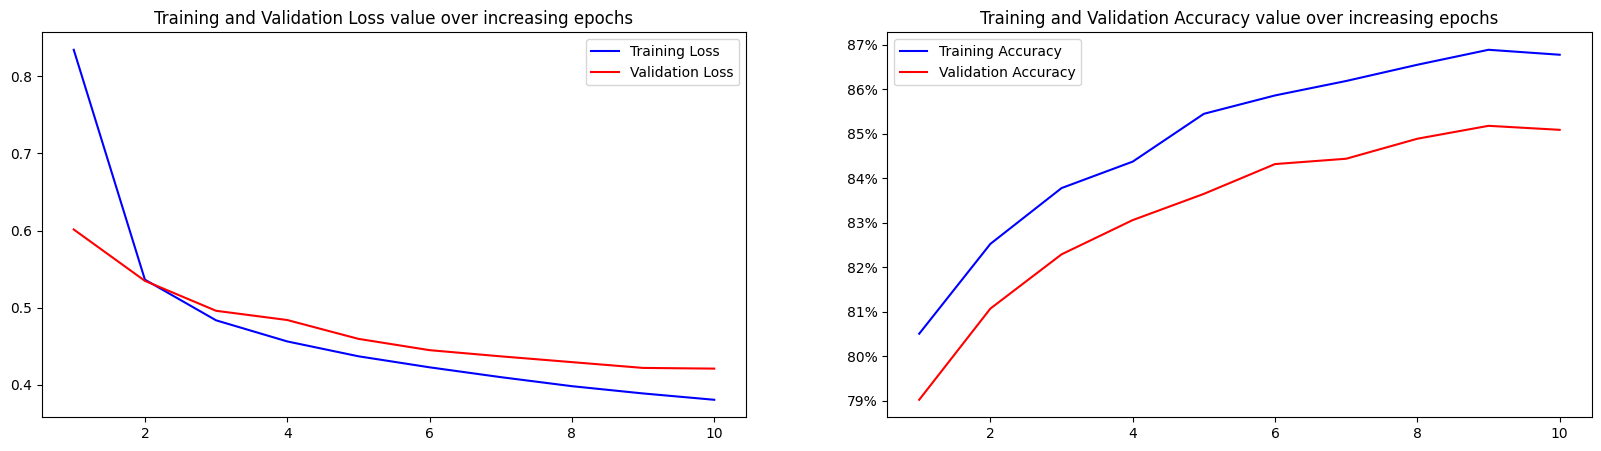

In [24]:
def display_train_validation_results(number_epoch,train_losses, train_accuracies, validation_losses, validation_accuracies):
    epochs = np.arange(number_epoch)+1
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Training and Validation Loss value over increasing epochs')
    plt.plot(epochs, train_losses,'b', label='Training Loss')
    plt.plot(epochs, validation_losses,'r', label='Validation Loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Training and Validation Accuracy value over increasing epochs')
    plt.plot(epochs, train_accuracies,'b', label='Training Accuracy')
    plt.plot(epochs, validation_accuracies,'r', label='Validation Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()

display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

#### Change Batch size from 32 to 10,000

In [65]:
train_data_loader, validation_data_loader = get_data(10000)     #change batch size to 10000

In [61]:
model,loss_function, optimizer = build_model(optimizer=SGD, lr=1e-2)

In [27]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 2.280
Train Accuracy: 17%
Validation Loss: 2.248
Validation Accuracy: 16%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 2.228
Train Accuracy: 28%
Validation Loss: 2.200
Validation Accuracy: 28%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 2.182
Train Accuracy: 38%
Validation Loss: 2.156
Validation Accuracy: 38%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 2.138
Train Accuracy: 45%
Validation Loss: 2.114
Validation Accuracy: 44%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 2.097
Train Accuracy: 50%
Validation Loss: 2.074
Validation Accuracy: 49%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 2.056
Train Accuracy: 54%
Validation Loss: 2.034
Validation Accuracy: 53%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 2.017
Train Accuracy: 58%
Validation Loss: 1.995


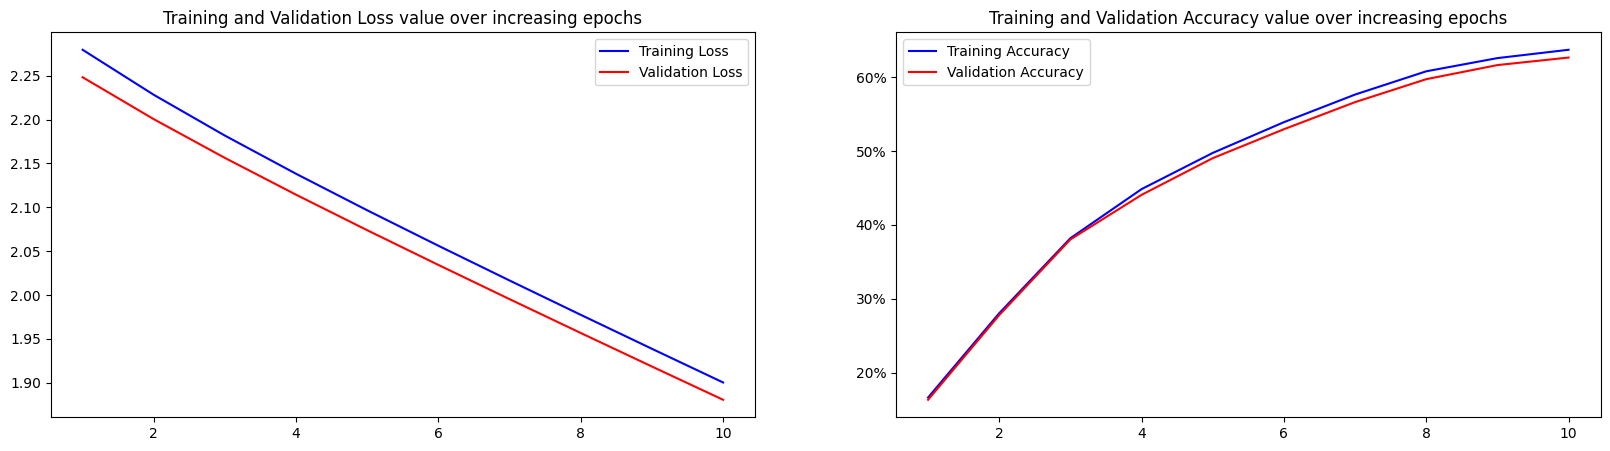

In [28]:
display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

Having a lower batch size generally helps in achieving optimal accuracy when you have a small number of epochs, but it should not be so low that training time is impacted.

## 4. The Impact of Varying the Loss Optimizer

In [30]:
from torch.optim import Adam

Modify the build model function by replacing the SGD optimizer with Adam optimizer

In [66]:
train_data_loader, validation_data_loader = get_data(32)         #change batch size to 32

In [60]:
model,loss_function, optimizer = build_model(optimizer=Adam , lr= 1e-2)

In [36]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 0.357
Train Accuracy: 86%
Validation Loss: 0.464
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.355
Train Accuracy: 88%
Validation Loss: 0.471
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.356
Train Accuracy: 88%
Validation Loss: 0.472
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.349
Train Accuracy: 86%
Validation Loss: 0.534
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.352
Train Accuracy: 88%
Validation Loss: 0.461
Validation Accuracy: 86%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.347
Train Accuracy: 88%
Validation Loss: 0.480
Validation Accuracy: 85%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.341
Train Accuracy: 88%
Validation Loss: 0.479


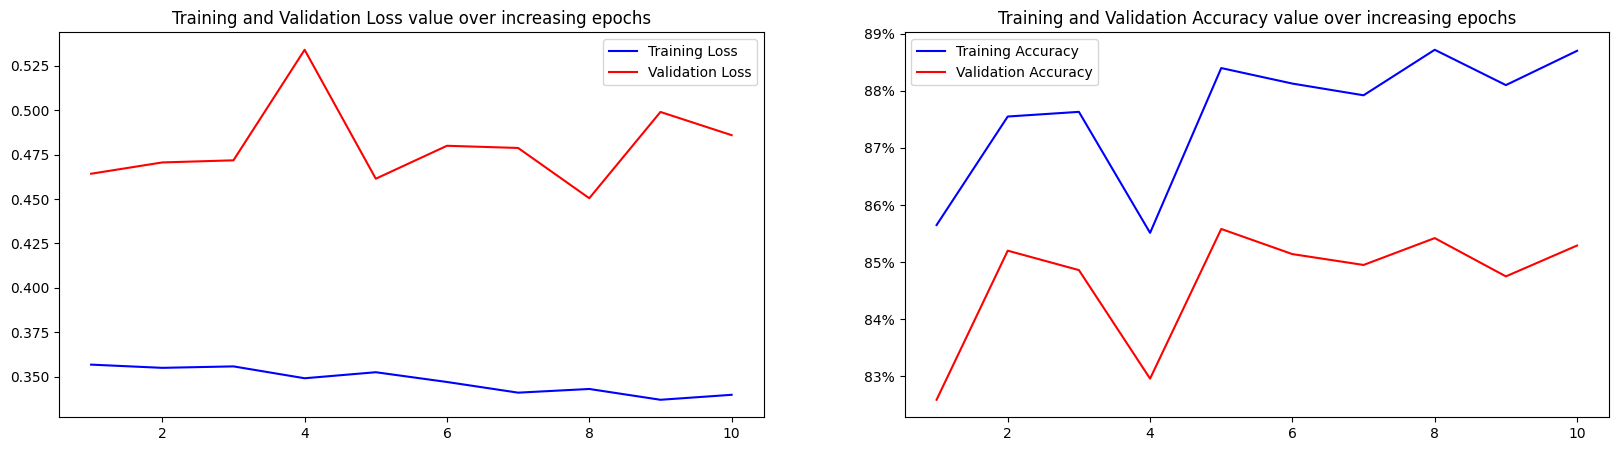

In [37]:
display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

In the previous code, Adam optimizer achives the same accuracy of SGD but faster. Generally, this optimizer achieve optimal accuracy faster

## 5. The Impact of Varying the Learning Rate

The learning rate plays a key role in obtaining optimal weight values. The weight values gradually move toward the optimal value when the learning rate is small, while the weight value oscillates at a non-optimal value when the learning rate is large.

### High Learning Rate (lr = 0.1)

The only change will be in the build model function where lr of the optimizer will be set to 0.1

In [67]:
train_data_loader, validation_data_loader = get_data(32)         #change batch size to 32

In [63]:
model,loss_function, optimizer = build_model(optimizer = Adam , lr=1e-1)

In [48]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 2.882
Train Accuracy: 29%
Validation Loss: 1.853
Validation Accuracy: 29%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 1.997
Train Accuracy: 27%
Validation Loss: 1.895
Validation Accuracy: 27%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 1.940
Train Accuracy: 22%
Validation Loss: 2.030
Validation Accuracy: 22%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 1.926
Train Accuracy: 29%
Validation Loss: 1.906
Validation Accuracy: 29%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 1.884
Train Accuracy: 28%
Validation Loss: 1.897
Validation Accuracy: 28%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 1.892
Train Accuracy: 27%
Validation Loss: 1.899
Validation Accuracy: 27%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 1.835
Train Accuracy: 33%
Validation Loss: 1.845


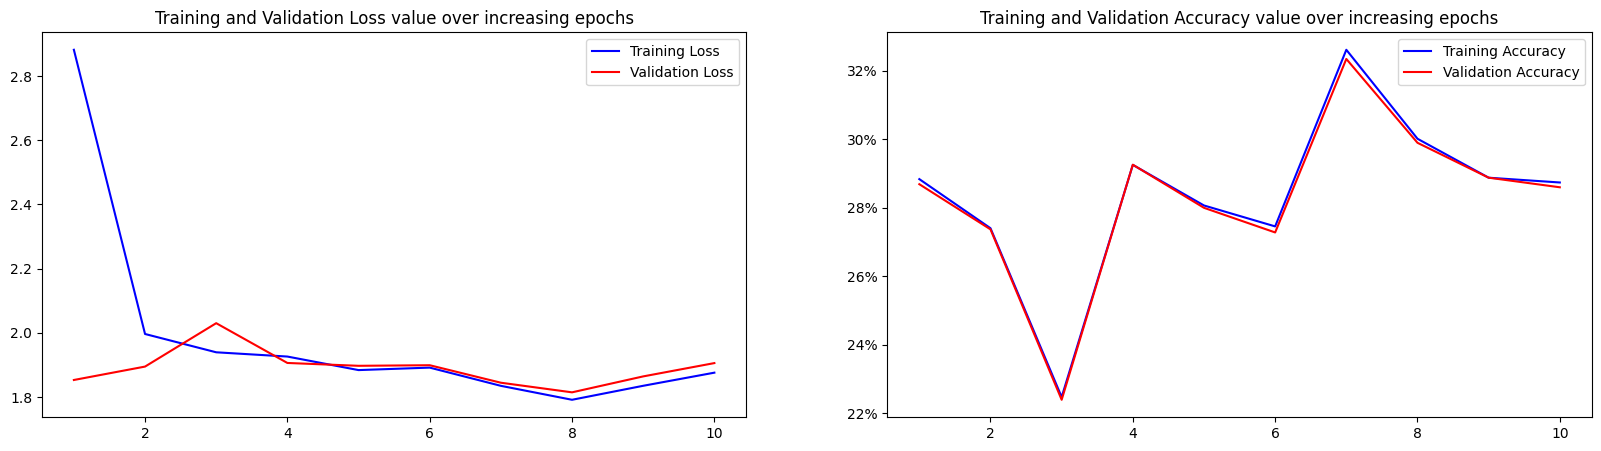

In [49]:
display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

As the previous plots illustarte, high learning rate (lr =0.1) achives less accurate results compared to when the lr = 0.01

### Medium Learning Rate (lr = 0.001)

In [53]:
train_data_loader, validation_data_loader = get_data(32)

In [64]:
model,loss_function, optimizer = build_model(optimizer=Adam, lr=1e-3)

In [55]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(10)

Epoch: 1
Train Loss: 0.473
Train Accuracy: 87%
Validation Loss: 0.396
Validation Accuracy: 86%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.357
Train Accuracy: 88%
Validation Loss: 0.372
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.319
Train Accuracy: 90%
Validation Loss: 0.342
Validation Accuracy: 88%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.296
Train Accuracy: 90%
Validation Loss: 0.342
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.279
Train Accuracy: 91%
Validation Loss: 0.326
Validation Accuracy: 88%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.262
Train Accuracy: 90%
Validation Loss: 0.364
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.250
Train Accuracy: 91%
Validation Loss: 0.353


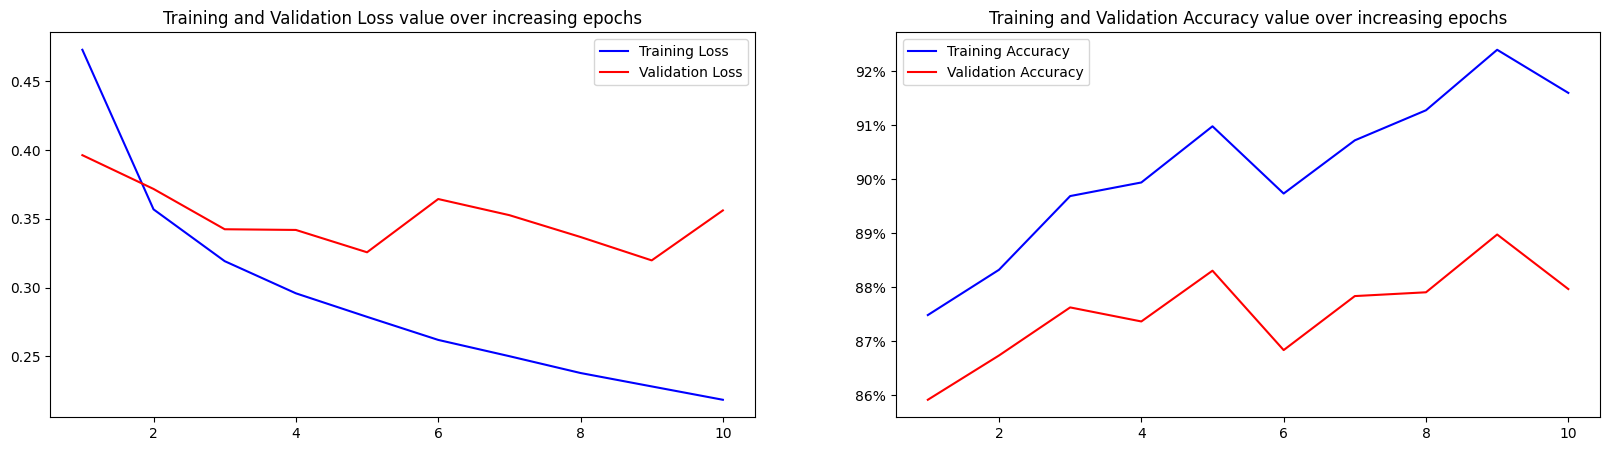

In [56]:
display_train_validation_results(10,train_losses, train_accuracies, validation_losses, validation_accuracies)

For this model, it achieve more accurate results when the learning rate set 0.001 compared to 0.1 or 0.01

### Low Learning Rate (lr = 0.00001)

we'll reduce the learning rate of the optimizer to 0.00001 and run the model for a longer number of epochs (100)

In [68]:
train_data_loader, validation_data_loader = get_data(32)

In [71]:
model,loss_function, optimizer = build_model(optimizer=Adam, lr=1e-5)

In [74]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(100)

Epoch: 1
Train Loss: 1.171
Train Accuracy: 74%
Validation Loss: 0.792
Validation Accuracy: 73%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.690
Train Accuracy: 79%
Validation Loss: 0.647
Validation Accuracy: 78%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.593
Train Accuracy: 82%
Validation Loss: 0.586
Validation Accuracy: 80%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.544
Train Accuracy: 82%
Validation Loss: 0.550
Validation Accuracy: 81%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.513
Train Accuracy: 83%
Validation Loss: 0.527
Validation Accuracy: 82%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.490
Train Accuracy: 84%
Validation Loss: 0.509
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.474
Train Accuracy: 84%
Validation Loss: 0.494


Train Loss: 0.305
Train Accuracy: 89%
Validation Loss: 0.361
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 55
Train Loss: 0.303
Train Accuracy: 89%
Validation Loss: 0.362
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 56
Train Loss: 0.302
Train Accuracy: 89%
Validation Loss: 0.359
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 57
Train Loss: 0.301
Train Accuracy: 89%
Validation Loss: 0.357
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 58
Train Loss: 0.299
Train Accuracy: 89%
Validation Loss: 0.357
Validation Accuracy: 87%
<--------------------------------------------------------->
Epoch: 59
Train Loss: 0.298
Train Accuracy: 90%
Validation Loss: 0.356
Validation Accuracy: 88%
<--------------------------------------------------------->
Epoch: 60
Train Loss: 0.296
Train Accuracy: 90%
Validation Loss: 0.354
Val

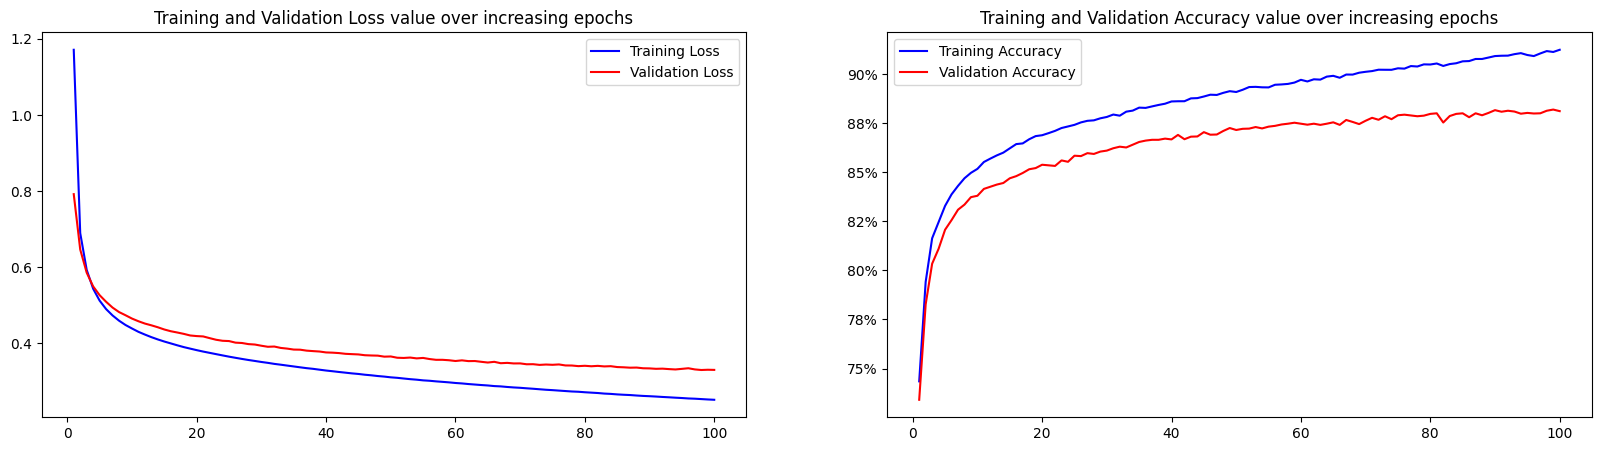

In [75]:
display_train_validation_results(100,train_losses, train_accuracies, validation_losses, validation_accuracies)

The model is learing by far slower compared to the high and medium learning rate. It took almost ~100 epochs to achive a similar rseults to the model with medium learning rate (only ten epochs)

## 6. The Impact of Learning Rate Annealing

So far, we have initialized a learning rate, and it has remained the same across all the epochs while training the model. This calls for having a high learning rate initially and gradually lowering it later on as the model achieves near-optimal accuracy. This can be done by monitoring validation loss and if the validation loss does not decrease (let's say, over the previous x epochs), then we reduce the learning rate.

In [77]:
from torch.optim import lr_scheduler

In [80]:
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,                                  #reduce learning rate parameter of optimizer
    factor=0.5 ,                                # by a factor of 0.5 
    patience=0 , 
    threshold=0.001,                            # if a certain value (validation loss) does not improve by this threshold value
    verbose=True , 
    min_lr=1e-5 ,                               #learning rate can not be below 1e-5
    threshold_mode='abs')

In [83]:
def train_with_validation(epoch_number):
    train_losses, train_accuracies = [], []   
    validation_losses, validation_accuracies = [], [] 
    for epoch in range (epoch_number):               
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       

        for batch in (iter(train_data_loader)):      
            input_batch, targets = batch                     
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  

            batch_losses.append(batch_loss)                               
        epoch_loss = np.array(batch_losses).mean()                        
        train_losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        train_accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        
        for batch in (iter(validation_data_loader)):
            input_batch, targets = batch
            validation_loss_value = get_validation_loss_value(input_batch, targets, model)
            validation_accuracy = get_accuracy(input_batch, targets, model)
            scheduler.step(validation_loss_value)  #the scheduler should be activated 
                                                   #whenever the validation loss does not decrease over consecutive epochs.
            
            
        validation_losses.append(validation_loss_value)
        print(f"Validation Loss: {validation_loss_value:0.3f}")
        valiation_epoch_accuracy = np.mean(validation_accuracy)
        print(f"Validation Accuracy: {valiation_epoch_accuracy*100:0.0f}%")
        validation_accuracies.append(valiation_epoch_accuracy)
        print('<--------------------------------------------------------->')
        
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [84]:
train_data_loader, validation_data_loader = get_data(32)

In [85]:
model,loss_function, optimizer = build_model(optimizer=Adam, lr=1e-5)

In [86]:
train_losses, train_accuracies, validation_losses, validation_accuracies = train_with_validation(30)

Epoch: 1
Train Loss: 1.180
Train Accuracy: 75%
Validation Loss: 0.795
Validation Accuracy: 74%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 0.693
Train Accuracy: 80%
Validation Loss: 0.651
Validation Accuracy: 78%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 0.594
Train Accuracy: 81%
Validation Loss: 0.586
Validation Accuracy: 80%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 0.544
Train Accuracy: 83%
Validation Loss: 0.550
Validation Accuracy: 81%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 0.513
Train Accuracy: 83%
Validation Loss: 0.526
Validation Accuracy: 82%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 0.491
Train Accuracy: 84%
Validation Loss: 0.510
Validation Accuracy: 83%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 0.474
Train Accuracy: 84%
Validation Loss: 0.494


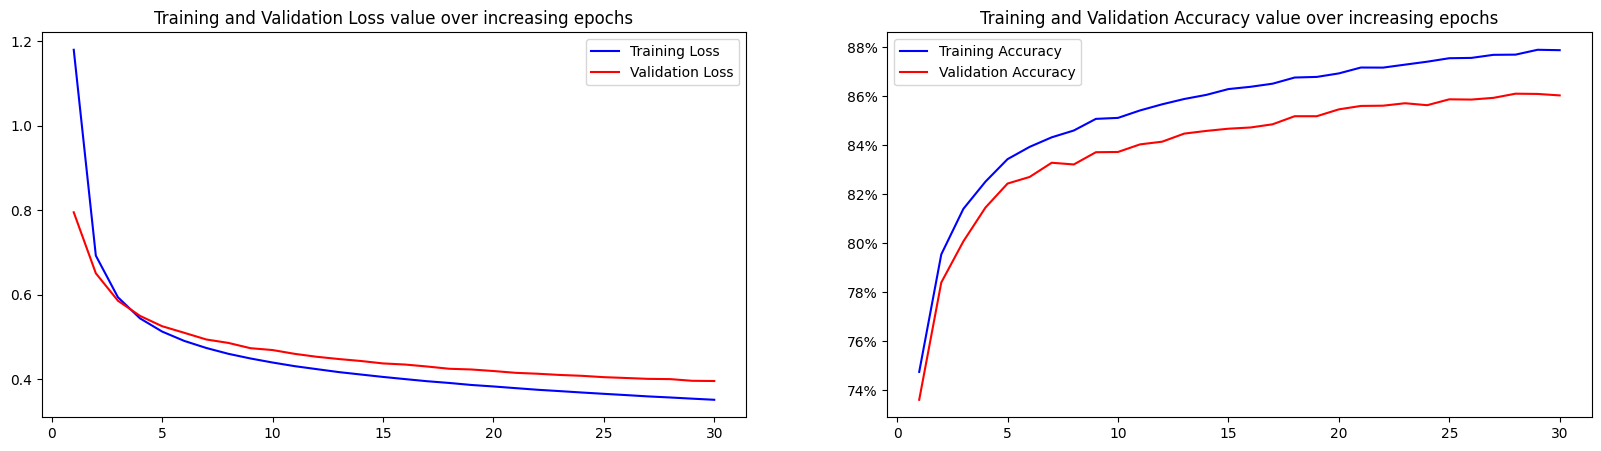

In [88]:
display_train_validation_results(30,train_losses, train_accuracies, validation_losses, validation_accuracies)